# Exploring Bayesian Linear Regression

We are interested in learning a posterior parameter distribution $$p(\mathbf{\theta}|\mathcal{X},\mathcal{Y})=\frac{p(\mathcal{Y}|\mathcal{X},\mathbf{\theta})p(\mathbf{\theta})}{p(\mathcal{Y}|\mathcal{X})}$$ We start by exploring the distribution over regression functions defined by the parameter prior, $p(\mathbf{\theta})$. For each sample $\mathbf{\theta}_i$, a regression function $f_i(\cdot)=\mathbf{\theta}_i^T\mathbf{\phi}(\cdot)$ is implicitly defined.

Note that we are still using the following linear regression model:
$$y=\phi^T(\mathbf{x})+\epsilon,$$ $$\epsilon\sim\mathcal{N}(0,\sigma^2).$$

Alternatively, this model can be summarized by $$y\sim\mathcal{N}(y|\mathcal{\phi}^T(\mathbf{x})\mathbf{\theta},\sigma^2).$$

Note that when considering this function distribution induced by the parameter prior below, the measurement noise $\epsilon$ and its effects are ignored.

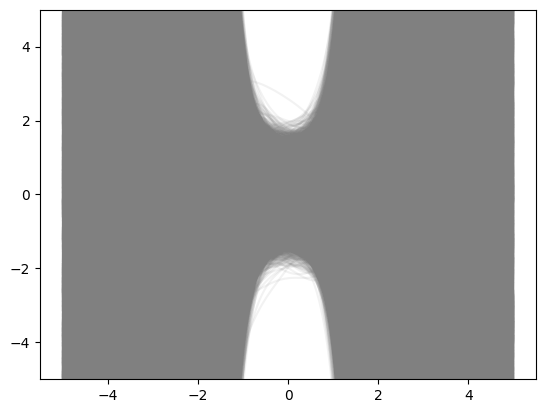

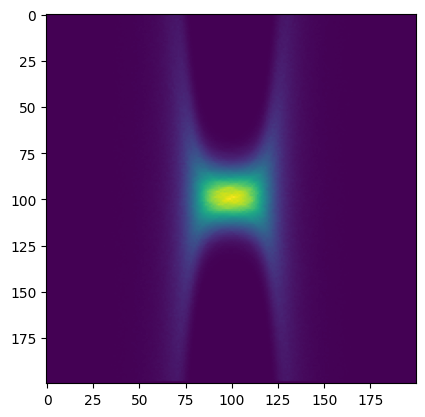

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng as rng

sample_size = 200
prior_sample_size = int(1e5)
poly_deg = 5

K = poly_deg + 1

# Specifying the prior distribution p(θ) = N(m_0, S_0)
m_0 = np.zeros(K)
S_0 = 0.25 * np.eye(K)

# Take random sample from prior distribution
prior_sample = rng().multivariate_normal(m_0, S_0, prior_sample_size)

# Build design matrix
examples = np.linspace(-5, 5, sample_size)
Φ = [[x**i for i in range(K)] for x in examples]

# Computing and plotting function samples
fig, ax = plt.subplots()
ax.set_ylim([-5,5])

# For the heat map
functional_res = 200
heat_map = np.zeros((functional_res, sample_size))
for i, θ_i in enumerate(prior_sample):
    f_i = Φ@θ_i
    ax.plot(examples, f_i, color='grey', alpha=0.1)
    for j, val in enumerate(f_i):
        # j is column idx in heat map
        
        # k is row idx in heat map
        if val > 5 or val < -5:
            continue
        
        k = int(((val + 5) / 10) * (functional_res - 1))
        assert type(k) is int 
        assert k < functional_res, f"{k}"
        assert k >= 0, f"{k}"
        
        heat_map[k,j] += 1

plt.show()
plt.figure()
plt.imshow(heat_map)

#ax.plot(examples, f_i, color='grey', alpha=0.1)

## Plotting Functional Confidence Intervals

*Idea:* Draw samples from functional distribution. We can do this because there is a normal distribution at each point along the domain.

[]

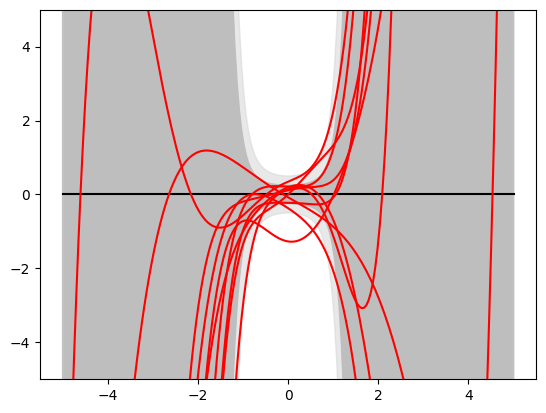

In [2]:
# Didn't end up needing this function
def noise_free_functional_sample(x, deg, N, μ_prior, Σ_prior):
    ϕ = np.array([x**i for i in range(deg+1)])
    return rng().normal(ϕ@μ_prior, ϕ@Σ_prior@ϕ, N)

means = []
upper_sigma = []
upper_two_sigma = []
lower_sigma = []
lower_two_sigma = []
for i, x in enumerate(examples):
    ϕ = np.array([x**i for i in range(poly_deg+1)])
    sigma = ϕ@S_0@ϕ
    means.append(ϕ@m_0)
    upper_sigma.append(means[i] + sigma)
    upper_two_sigma.append(means[i] + 2*sigma)
    lower_sigma.append(means[i] - sigma)
    lower_two_sigma.append(means[i] - 2*sigma)
    
fig, ax = plt.subplots()
ax.set_ylim([-5,5])
ax.fill_between(examples, lower_sigma, upper_sigma, color='darkgrey')
ax.fill_between(examples, lower_two_sigma, upper_two_sigma, color='lightgrey', alpha=0.5)
ax.plot(examples, means, color='black')

prior_sample_size = 10

# Take random sample from prior distribution
prior_sample = rng().multivariate_normal(m_0, S_0, prior_sample_size)
for i, θ_i in enumerate(prior_sample):
    f_i = Φ@θ_i
    ax.plot(examples, f_i, color='red')

plt.plot()

## Next, exploring the parameter posterior $p(\mathbf{\theta}|\mathcal{X}, \mathcal{Y})$

The parameter posterior can be shown to be $$p(\mathbf{\theta}|\mathcal{X}, \mathcal{Y})=\mathcal{N}(\mathbf{\theta}|\mathbf{m_N}, S_N),$$ $$\newline$$ $$S_N = (S_0^{-1}+\sigma^{-2}\Phi^T\Phi)^{-1}$$ $$\mathbf{m_N}=S_N(S_0^{-1}\mathbf{m_0}+\sigma^{-2}\Phi^T\mathbf{y}).$$

Again we will explore the distribution of noise-free functions $f(\mathbf{x}_*)=\mathbf{\phi}^T(\mathbf{x}_*)\mathbf{\theta}$ induced by this parameter distribution.

Time to compute S_N and m_N: 0.00016999244689941406


[]

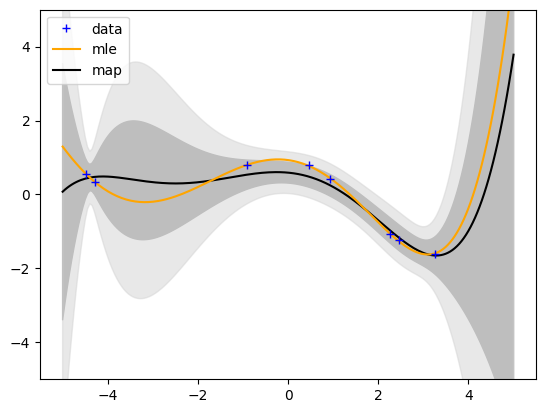

In [297]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng as rng

sample_size = 200
θ_sample_size = int(1e1)
poly_deg = 5

K = poly_deg + 1

# Specifying the prior distribution p(θ) = N(m_0, S_0)
m_0 = np.zeros(K)
S_0 = 0.25 * np.eye(K)

# Take random sample from prior distribution
prior_sample = rng().multivariate_normal(m_0, S_0, θ_sample_size)

# Compute training set and build design matrix
σ = 0.5
train_size = 8
x_train = np.sort(np.random.uniform(-5, 5, train_size))
Φ = np.array([[x**i for i in range(K)] for x in x_train])

# Don't include the measurement noise
y_train = -np.sin(x_train/5) + np.cos(x_train) # + np.random.normal(0, σ, train_size)

# Build test set
test_size = 200
x_test = np.linspace(-5, 5, test_size)
Φ_test = np.array([[x**i for i in range(K)] for x in x_test])
y_test = -np.sin(x_test/5) + np.cos(x_test) + np.random.normal(0, σ, test_size)

# Computing the parameter posterior
start = time.time()
S_N = np.linalg.inv(np.linalg.inv(S_0) + σ**(-2)*Φ.T@Φ)
m_N = S_N@(np.linalg.inv(S_0)@m_0 + σ**(-2)*Φ.T@y_train)
stop = time.time()
print(f"Time to compute S_N and m_N: {stop-start}")

posterior_sample = rng().multivariate_normal(m_N, S_N, θ_sample_size)

test_examples = list(zip(x_test, y_test))

θ_mle = np.linalg.solve(Φ.T@Φ, Φ.T@y_train)

mle = []
means = []
upper_sigma = []
upper_two_sigma = []
lower_sigma = []
lower_two_sigma = []
for i, (x, y) in enumerate(test_examples):
    ϕ = np.array([x**i for i in range(K)])
    var = ϕ@S_N@ϕ
    sigma = np.sqrt(var)
    means.append(ϕ@m_N)
    upper_sigma.append(means[i] + sigma)
    upper_two_sigma.append(means[i] + 2*sigma)
    lower_sigma.append(means[i] - sigma)
    lower_two_sigma.append(means[i] - 2*sigma)
    
    mle.append(ϕ@θ_mle)
    
fig, ax = plt.subplots()
ax.set_ylim([-5,5])
ax.fill_between(x_test, lower_sigma, upper_sigma, color='darkgrey')
ax.fill_between(x_test, lower_two_sigma, upper_two_sigma, color='lightgrey', alpha=0.5)
map_est, = ax.plot(x_test, means, color='black')

# Optionally, sample from posterior and plot results
# for i, θ_i in enumerate(posterior_sample):
#     f_i = Φ_test@θ_i
#     ax.plot(x_test, f_i, color='red', alpha=0.1)

mle_handle, = ax.plot(x_test, mle, color='orange')   
train_pts, = ax.plot(x_train, y_train, '+', color='b')   
ax.legend([train_pts, mle_handle, map_est], ["data", "mle", "map"])

plt.plot()